# Inspect and tweak NIRSpec master background

The goal of this notebook is to provide interactive widgets to users to help them evaluate whether their NIRSpec master background subtraction is any good. Possible problems include:

 - The background is varying spatially across the detector (so a single average isn't good)
 - The wavelengths aren't lining up
 - There are some sources in some of the background aperture
 - There is some contamination from open shutters affecting background apertures
 
Tools might include:

 1. A widget to let the user step through individual background spectra (1D). 
 2. Statistics on the individual background spectra to identify outliers
     1. basic stats could be in an array, to allow numpy tools to work on them
 3. Visualization of mean (over $\lambda$) background (or background over a wavelength region) vs. position on the detector
 4. 2d view where each row (or tile of identical rows for visualization) is a single background 1D spectrum and the columns are just ID numbers. Outliers will be very easy to see in this representation. A widget would allow the user to get the IDs or simply mark the outliers for rejection before re-estimating the master background.
 5. A tool to make customized master backgrounds associating certain background apertures with certain sources.
 
Not sure about architecture, but it might be simplest for the user if all the background tools are in one package. Possibly as a class. I'll pretend it's that way. Then the calls to the steps above might be one-liners after reading the data into the class:

```
from jwsttools import MOSMasterBackground

bkgtool = MOSMasterBackground(filename) # or MOSMasterBackground(x1d or x2d datamodel)
bkgtool.plot1Dwidget() # For item (1)
```

We'll probably want a fair amount of metadata associated with each background spectrum: some sort of ID, positions in various coordinates, exposure time, time of year, price of eggs in China...


In [50]:
from jwst import datamodels
from astropy.io import fits
import numpy as np
import specutils
from specutils import Spectrum1D, SpectrumList
from astropy import nddata
import astropy.units as u
from scipy import interpolate
import pandas as pd
from astropy.table import Table

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

## Which data set to use?

The one in box only has a few slits, so maybe isn't the best example:

  - https://stsci.box.com/shared/static/v1h9jpg24rusalpui2jpqyldlrqjmv7k.fits

The following has 71 slits:

  - F170LP-G235M_MOS_observation-6-c0e0_001_DN_NRS1_mod_updatedHDR_x1d.fits
  - You can find on box at https://stsci.box.com/v/x1dhackdayfeb18
  
No guarantee that `x1d` file format is current though (it almost certainly is not -- opening it fails with the development version of `jwst.datamodels`).

In [52]:
#filename = 'https://stsci.box.com/v/x1dhackdayfeb18'
filename = 'F170LP-G235M_MOS_observation-6-c0e0_001_DN_NRS1_mod_updatedHDR_x1d.fits'
hdu = fits.open(filename)
#hdu.info()

Read it into a list of Spectrum1D objects

In [53]:
spectrumlist = SpectrumList.read('F170LP-G235M_MOS_observation-6-c0e0_001_DN_NRS1_mod_updatedHDR_x1d.fits',format='JWST')

Create a little class to store store the spectrum list and the means, a method to interpolate to a common wavelength grid, and a method to make a 2d stack.

In [54]:
class MOSMasterBackground:

    def __init__(self,spectrumlist):
        self.speclist = spectrumlist
        self.meanbkg = np.array([s.flux.value.mean() for s in self.speclist]) # Remove units for the moment
        self.create_interpolators()
    
    def create_interpolators(self):
        self.interpolator = []
        for s in self.speclist:
            self.interpolator += [interpolate.interp1d(s.spectral_axis.value,s.flux,
                                                       bounds_error=False,fill_value=(0.,0.))]
    def twod_stack(self,wavelengths):
        _stack = np.zeros((len(self.speclist),len(wavelengths)))
        for row,interp in enumerate(self.interpolator):
            _stack[row,:] = interp(wavelengths)
        self.stack = np.repeat(_stack,10,axis=0) # Repeat a few times for visualization

In [55]:
bkg = MOSMasterBackground(spectrumlist)

## Background 1D inspection widget
This next step would be a widget to allow the user to scrub through the background spectra one by one:

```bkgtool.plot1Dwidget()```

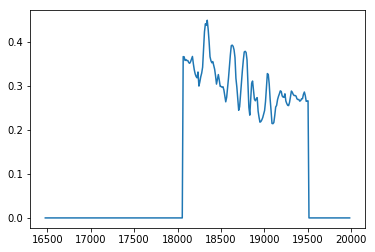

In [56]:
plt.plot(bkg.speclist[4].wavelength,bkg.speclist[4].flux)

## Statistics on the individual background spectra to identify outliers
Glue linking would let you highight outliers here on a linked display, e.g. of the apertures projected on the sky (a NIRCam image), or the 2D stack of background spectra mentioned in tool 4.

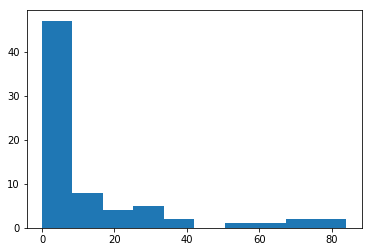

In [57]:
n,bins,patches = plt.hist(bkg.meanbkg)

The advantage of having some precomputed stuff is to make it easy to use numpy to do selection and filtering, e.g. -- finding the 5 entries with the highest background.

In [58]:
high5 = np.argsort(bkg.meanbkg)[-5:]
high5

array([59, 20, 45, 51, 25])

## 2D stacked display
Given the aspect ratio, best if this is expandable separately in x and y axes. Expand enough to allow cursor selection of the outliers.

In [59]:
wavelengths = np.linspace(1.65,2.0,1000)
bkg.twod_stack(wavelengths)

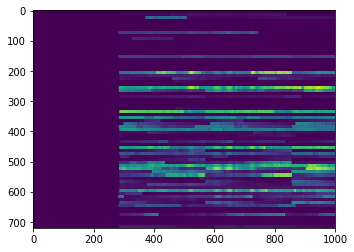

In [60]:
plt.imshow(bkg.stack)

## Plot mean background vs position on the detector
Some sort of heat map?

In [61]:
ra = np.array([h.header['SLIT_RA'] for h in hdu[1:-1]])
dec = np.array([h.header['SLIT_DEC'] for h in hdu[1:-1]])

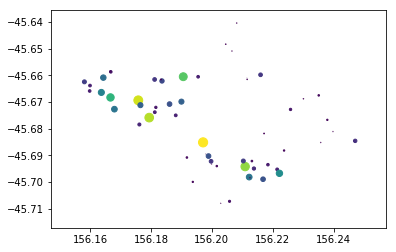

In [62]:
plt.scatter(ra,dec,s=bkg.meanbkg,c=bkg.meanbkg)